# Imports

In [1]:
import sys
import os
import pandas as pd


# ADD PROJECT ROOT TO PATH (2 levels above)
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)


# NUMERICAL & IMAGE PROCESSING
import numpy as np
import cv2
import pydicom
import matplotlib.pyplot as plt


# RTSTRUCT PROCESSING
from src.preprocessing.rtstruct.rtstruct_io import (
    load_rtstruct,
    load_ct_images,
    read_dicom_image
)

from src.preprocessing.rtstruct.rtstruct_parsing import (
    extract_tumor_bboxes
)

from src.preprocessing.rtstruct.rtstruct_to_yolo import (
    save_yolo_format,
    save_images_as_jpeg,
    load_yolo_labels,
    draw_bboxes
)

from src.preprocessing.rtstruct.rtstruct_visualization import (
    visualize_bboxes,
    display_all_images_for_patient
)

from src.preprocessing.rtstruct.rtstruct_batch_processing import (
    process_all_patients
)



# NSCLC FILE PREPROCESSING
from src.utils.file_utils import (
    rename_files_in_folder,
    count_files_by_prefix,
    update_label_files
)

from src.utils.subject_utils import (
    count_files_and_patients,
    get_patient_images,
    get_patient_images_v2,       
    sample_patients_by_image_count,
    sample_patients
)


# NSCLC SPLITTING PIPELINE
from src.splitting.dataset_splitting import (
    split_data_nsclc,
    copy_sampled_files,
    copy_files,
    main
)

# Patient Processing
from src.preprocessing.rtstruct.rtstruct_batch_processing import process_all_patients

plt.rcParams["figure.dpi"] = 120

# Read Image rtstruct files

Available ROIs: {'1': 'Lung-Right', '2': 'Lung-Left', '3': 'Heart', '4': 'Esophagus', '5': 'Spinal-Cord', '6': 'GTV-1'}
Loaded 111 CT slices.


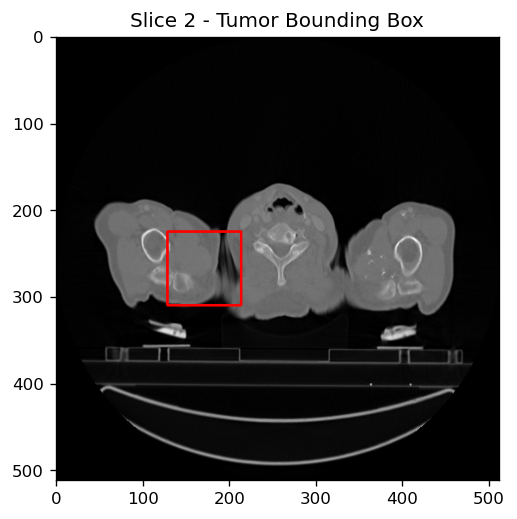

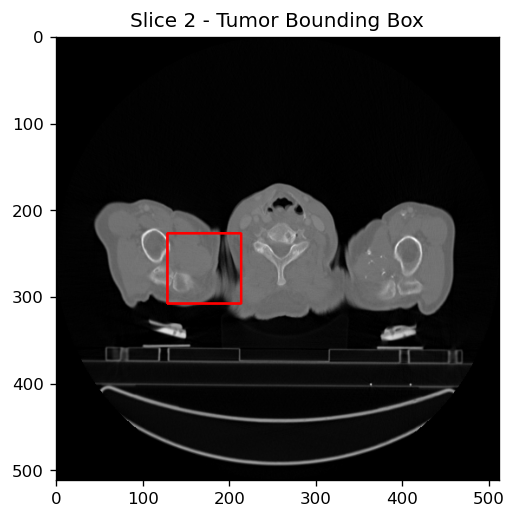

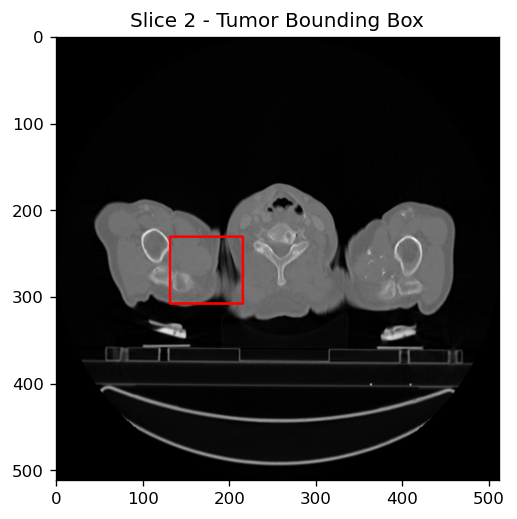

In [7]:
# File paths 
rtstruct_path = "../../data/raw/NSCLC/NSCLC_Radiomics/LUNG1-002/01-01-2014-StudyID-NA-85095/4.000000-NA-45931/1-1.dcm"
ct_dir = "../../data/raw/NSCLC/NSCLC_Radiomics/LUNG1-002/01-01-2014-StudyID-NA-85095/1.000000-NA-61228"

# Load RTSTRUCT and CT images
rtstruct, roi_map = load_rtstruct(rtstruct_path)
ct_slices = load_ct_images(ct_dir)

# Extract and visualize bounding boxes
bboxes = extract_tumor_bboxes(rtstruct, roi_map, ct_slices[:3])
if bboxes:
    visualize_bboxes(ct_slices[:3], bboxes[:3])

## Process rtstruct files

In [10]:
# Define paths
image_dir = "../../data/yolo/NSCLC/yolo_images"
label_dir = "../../data/yolo/NSCLC/yolo_labels"


# Run the display function for a selected patient
selected_patient = "E_LUNG1-183"  # Change this to select a different patient
#display_all_images_for_patient(image_dir, label_dir, selected_patient)

# Preprocessing Images + Image Sampling

In [36]:
# Define file paths
image_dir = "../../data/yolo/NSCLC/yolo_images"
label_dir = "../../data/yolo/NSCLC/yolo_labels"

# Map histology type to prefix
histology_prefix = {
    "squamous cell carcinoma": "G",
    "large cell": "E",
    "adenocarcinoma": "A"
}

# Convert dataframe to a dictionary for fast lookup
patient_to_histology = df.set_index("PatientID")["Histology"].to_dict()

# Rename images and labels
rename_files_in_folder(image_dir, patient_to_histology, histology_prefix)
rename_files_in_folder(label_dir, patient_to_histology, histology_prefix)

print("Renaming complete!")

Renaming complete!


In [38]:
# Define prefixes for histology types
histology_prefixes = ["G", "E", "A"]

# Count images and unique patients in images
image_counts, image_patient_counts = count_files_and_patients(image_dir, histology_prefixes)

# Count labels and unique patients in labels
label_counts, label_patient_counts = count_files_and_patients(label_dir, histology_prefixes)

# Display results
print("Image & Label Counts by Histology Prefix:")
for prefix in histology_prefixes:
    print(f"  {prefix}: {image_counts.get(prefix, 0)} images, {label_counts.get(prefix, 0)} labels")

print("\nUnique Patient Counts by Histology Prefix (Images & Labels):")
for prefix in histology_prefixes:
    print(f"  {prefix}: {image_patient_counts.get(prefix, 0)} patients in images, {label_patient_counts.get(prefix, 0)} patients in labels")

Image & Label Counts by Histology Prefix:
  G: 2735 images, 2735 labels
  E: 2026 images, 2026 labels
  A: 952 images, 952 labels

Unique Patient Counts by Histology Prefix (Images & Labels):
  G: 152 patients in images, 152 patients in labels
  E: 114 patients in images, 114 patients in labels
  A: 51 patients in images, 51 patients in labels


In [39]:
# Define mapping for histology prefix to class number
histology_class_map = {
    "A": "0",  # Adenocarcinoma
    "E": "2",  # Large cell
    "G": "3"   # Squamous cell carcinoma
}

# Run the function to update labels
update_label_files(label_dir, histology_class_map)

print("All label files updated successfully!")

Updated: E_LUNG1-124_09-28-2006-StudyID-NA-06637_44.txt
Updated: A_LUNG1-052_01-01-2014-StudyID-NA-48653_81.txt
Updated: G_LUNG1-369_02-25-2010-NA-NA-41022_33.txt
Updated: G_LUNG1-193_07-26-2007-StudyID-NA-31252_45.txt
Updated: G_LUNG1-146_12-10-2006-StudyID-NA-54933_64.txt
Updated: G_LUNG1-376_02-27-2010-NA-NA-88135_56.txt
Updated: E_LUNG1-342_07-05-2009-StudyID-NA-33638_62.txt
Updated: G_LUNG1-146_12-10-2006-StudyID-NA-54933_70.txt
Updated: A_LUNG1-200_09-02-2007-NA-NA-56233_33.txt
Updated: G_LUNG1-296_10-03-2008-StudyID-NA-14251_58.txt
Updated: G_LUNG1-376_02-27-2010-NA-NA-88135_42.txt
Updated: E_LUNG1-140_01-01-2014-StudyID-NA-75276_36.txt
Updated: G_LUNG1-193_07-26-2007-StudyID-NA-31252_51.txt
Updated: A_LUNG1-052_01-01-2014-StudyID-NA-48653_95.txt
Updated: E_LUNG1-330_04-03-2009-NA-NA-46378_36.txt
Updated: E_LUNG1-124_09-28-2006-StudyID-NA-06637_50.txt
Updated: E_LUNG1-283_08-04-2008-StudyID-NA-17254_48.txt
Updated: E_LUNG1-038_01-01-2014-StudyID-NA-11498_138.txt
Updated: G_LUNG1

### Sample G patients do add to LUNG-PET-CT dataset

In [40]:
# Define output directories
output_image_dir = "....//data/yolo/yolo_2datasets/images"
output_label_dir = "....//data/yolo/yolo_2datasets/labels"

# Define prefixes for histology types
histology_prefixes = ["G"]

# Define the target number of images per class
TARGET_IMAGES = 500  # Change this to your desired number

# Get mapping of patients to their images
patient_images = get_patient_images(image_dir, histology_prefixes)

# Sample patients based on image count
selected_patients, selected_images = sample_patients_by_image_count(patient_images, TARGET_IMAGES)

# Copy sampled images and labels to the target directories
copy_sampled_files(selected_images, image_dir, label_dir, output_image_dir, output_label_dir)

# Display results
print("\n**Selected Patients and Images Per Histology Type**")
for prefix in histology_prefixes:
    print(f"\n{prefix}:")
    print(f"  Patients Selected: {len(selected_patients[prefix])}")
    print(f"  Images Selected: {len(selected_images[prefix])}")
    print("  Patient List (Patient ID | Image Count):")
    for patient_id, img_count in selected_patients[prefix]:
        print(f"    - {patient_id}: {img_count} images")


**Selected Patients and Images Per Histology Type**

G:
  Patients Selected: 56
  Images Selected: 512
  Patient List (Patient ID | Image Count):
    - LUNG1-386: 3 images
    - LUNG1-027: 3 images
    - LUNG1-167: 3 images
    - LUNG1-086: 4 images
    - LUNG1-098: 4 images
    - LUNG1-050: 4 images
    - LUNG1-325: 6 images
    - LUNG1-082: 6 images
    - LUNG1-296: 6 images
    - LUNG1-359: 6 images
    - LUNG1-321: 7 images
    - LUNG1-347: 7 images
    - LUNG1-061: 7 images
    - LUNG1-135: 7 images
    - LUNG1-253: 8 images
    - LUNG1-399: 8 images
    - LUNG1-404: 8 images
    - LUNG1-346: 8 images
    - LUNG1-369: 8 images
    - LUNG1-371: 8 images
    - LUNG1-295: 8 images
    - LUNG1-391: 8 images
    - LUNG1-150: 8 images
    - LUNG1-078: 9 images
    - LUNG1-365: 9 images
    - LUNG1-146: 9 images
    - LUNG1-334: 9 images
    - LUNG1-266: 9 images
    - LUNG1-379: 9 images
    - LUNG1-329: 10 images
    - LUNG1-206: 10 images
    - LUNG1-064: 10 images
    - LUNG1-122: 1

In [33]:
main(
    base_image_dir= "../data/yolo/NSCLC/yolo_images",
    base_label_dir= "../data/yolo/NSCLC/yolo_labels",
    output_dir= "../data/yolo/NSCLC/G_image_patients_sampled",
    prefix= "G",
    num_images=500
)

Process Concluded
